# Basic Imports

In [3]:
import self_distillation
import saving_loading
import generate
import wandb
import util
import os

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2

config_path=f"{cwd}/models/configs/celebahq-ldm-vq-4.yaml"
model_path=f"{cwd}/models/CelebA.ckpt"

!wandb login 4baa24c4fc6c8eed782cacb721d34977149d4fcb

original, sampler_original = util.create_models(config_path, model_path, student=False)
student, sampler_student = util.create_models(config_path, model_path, student=False)

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Administrator/.netrc


Loading model from c:\Diffusion_Thesis\cin_256/models/CelebA.ckpt


c:\Users\Administrator\anaconda3\envs\DSD\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from models/first_stage_models/vq-f4/model.ckpt with 0 missing and 55 unexpected keys
Training LatentDiffusion as an unconditional model.
Loading model from c:\Diffusion_Thesis\cin_256/models/CelebA.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from models/first_stage_models/vq-f4/model.ckpt with 0 missing and 55 unexpected keys
Training LatentDiffusion as an unconditional model.


In [ ]:
images, _ = util.compare_teacher_student_celeb(original, sampler_original, student, sampler_student, steps=[64, 32, 16, 8,  4, 2, 1])
images


In [6]:
del teacher, sampler_teacher, student, sampler_student, optimizer, scheduler
torch.cuda.empty_cache()

NameError: name 'teacher' is not defined

# Create teacher and student model

Both:

In [2]:
teacher, sampler_teacher, student, sampler_student = create_models(config_path, model_path, student=True)

Loading model from d:\OneDrive\Uni\Master_Project_AI\Code\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


Only the student or teacher:

(setting student=False will only return a single model)

In [2]:
# teacher, sampler_teacher = create_models(config_path, model_path, student=False)
student, sampler_student = create_models(config_path, model_path, student=False)

Loading model from d:\OneDrive\Uni\Master_Project_AI\Code\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


# Loading trained student as teacher

In [2]:
model_path_test = f"{cwd}/data/trained_models/10/student_intermediate_15.pt"
teacher, sampler_teacher, optimizer, scheduler = load_trained(model_path_test, config_path)

c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


## Generating WITHOUT intermediates saved

In [ ]:
img, x_T_copy, class_prompt, intermediates  = generate(teacher, sampler_teacher, steps=128, scale=3, keep_intermediates=False)
img

# Generating WITH intermediates saved

In [7]:
intermediates, starting_noise, class_prompt = return_intermediates_for_student(teacher, sampler_teacher, steps=250)

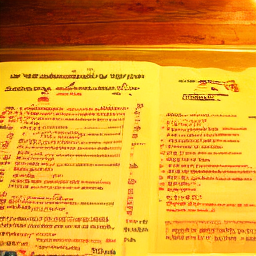

In [14]:
latent_to_img(teacher, intermediates[125])

# Creating a dataset

In [4]:
# dataset_path = f"{cwd}/data/pre_generated/teacher_128/"
# dataset_name = "teacher_128.pt"
# make_dataset(teacher, sampler_teacher, 501, 128, dataset_path, dataset_name)

100%|██████████| 500/500 [1:26:03<00:00, 10.33s/it]


# Training student from teacher directly

In [ ]:
wandb_session = wandb_log(name="test_loss", lr=1e-8, model=student, tags=["test"], notes="Just a test")

optimizer, scheduler = get_optimizer(sampler_student, iterations=20*20)
teacher_train_student(teacher, sampler_teacher, student, sampler_student, optimizer, scheduler, steps=20, generations=20, early_stop=True, session=wandb_session)

wandb.finish()

Extra, quick comparison:

In [ ]:
images, _ = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[1, 2, 4, 8, 16, 32, 64])
images

In [1]:
from util_celeb import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2

# config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
# model_path=f"{cwd}/models/cin256_original.ckpt"

config_path=f"{cwd}/models/configs/celebahq-ldm-vq-4.yaml"
model_path=f"{cwd}/models/CelebA.ckpt"


lr = 0.000001
steps = 64
generations =10


teacher, sampler_teacher, student, sampler_student = create_models(config_path, model_path, student=True)

wandb_session = wandb_log(name="CelebA_x0", lr=1e-4, model=student, tags=["test"], notes="Just a test")


optimizer, scheduler = get_optimizer(sampler_student, iterations=generations*steps, lr=lr)
teacher_train_student(teacher, sampler_teacher, student, sampler_student, optimizer, scheduler, steps=steps, generations=generations, early_stop=False, session=None)

# images, _ = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[1, 2, 4, 8, 16, 32])


del teacher, sampler_teacher, student, sampler_student, optimizer, scheduler
torch.cuda.empty_cache()

wandb.finish()

c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


Loading model from c:\Diffusion_Thesis\cin_256/models/CelebA.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from models/first_stage_models/vq-f4/model.ckpt with 0 missing and 55 unexpected keys
Training LatentDiffusion as an unconditional model.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pmobiluss. Use `wandb login --relogin` to force relogin


 10%|█         | 1/10 [00:48<07:16, 48.47s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 12.00 GiB total capacity; 11.15 GiB already allocated; 0 bytes free; 11.24 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [6]:
del teacher, sampler_teacher, student, sampler_student, optimizer, scheduler
torch.cuda.empty_cache()

# Train student from pre-generated teacher dataset

In [3]:
data_dir = f"{cwd}/data/pre_generated/teacher_128/"
datasets = os.listdir(data_dir)

In [ ]:
notes = """This is a serious attempt to distill the 128 step original teacher into a 64 step student, trained on 32000 instances"""
wandb_session = wandb_log(name="Train_student_on_128_pretrained", lr=0.00000001, model=student, tags=["distillation"], notes=notes)

optimizer, scheduler = get_optimizer(sampler_student, iterations=64*500)

dataset = torch.load(data_dir + datasets[0])
train_student_from_dataset(student, sampler_student, dataset, 64, optimizer, scheduler, early_stop=True, session=wandb_session)

wandb.finish()

save_model(sampler_student, optimizer, scheduler, name="lr8_scheduled", steps=64)

# Save and Loading trained models

In [ ]:
save_model(sampler_student, optimizer, scheduler, name="lr8_scheduled", steps=64)

In [ ]:
path = f"{cwd}/data/trained_models/64/student_lr8_scheduled.pt"
student, sampler_student, optimizer, scheduler = load_trained(path, config_path)

# Direct Comparison

In [4]:
images, _ = util.compare_teacher_student_celeb(teacher, sampler_teacher, student, sampler_student, steps=[1, 2, 4, 8, 16, 32, 64, 128])
images



NameError: name 'teacher' is not defined

# Distillation Loop (allnighter)

In [ ]:
from util_celeb import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2
!wandb login 4baa24c4fc6c8eed782cacb721d34977149d4fcb

ddim_steps = [128, 64, 32, 16, 8, 4, 2]

generations = 5000
config=f"{cwd}/models/configs/celebahq-ldm-vq-4.yaml"
original_model_path=f"{cwd}/models/CelebA.ckpt"

run_name = "PC_2000_1e-6"
tags = ["distillation", "CelebA", "PC"]
distill(ddim_steps, generations, run_name, config, original_model_path, lr=0.000001, tags=tags)

In [ ]:
def teacher_train_student(teacher, sampler_teacher, student, sampler_student, optimizer, scheduler, session=None, steps=20, generations=200, early_stop=True, run_name="test"):
    NUM_CLASSES = 1000
    generations = generations
    intermediate_generation = generations // 5
    ddim_steps_teacher = steps
    ddim_steps_student = int(ddim_steps_teacher / 2)
    TEACHER_STEPS = 2
    STUDENT_STEPS = 1
    ddim_eta = 0.01
    scale = 3.0
    updates = int(ddim_steps_teacher / TEACHER_STEPS)
    optimizer=optimizer
    averaged_losses = []
    teacher_samples = list()
    criterion = nn.MSELoss()
    instance = 0
    generation = 0
    

    a_t = np.linspace(0, 1, updates)

    all_losses = []
    ets = []
    with torch.no_grad():
        with student.ema_scope():
                
                sampler_teacher.make_schedule(ddim_num_steps=ddim_steps_teacher, ddim_eta=ddim_eta, verbose=False)
                sampler_student.make_schedule(ddim_num_steps=ddim_steps_teacher, ddim_eta=ddim_eta, verbose=False)
                # for class_prompt in tqdm.tqdm(torch.randint(0, NUM_CLASSES, (generations,))):
                uc = teacher.get_learned_conditioning(
                            {teacher.cond_stage_key: torch.tensor(1*[1000]).to(teacher.device)}
                            )
                sc = teacher.get_learned_conditioning(
                            {teacher.cond_stage_key: torch.tensor(1*[1000]).to(teacher.device)}
                            )
                with tqdm.tqdm(torch.randint(0, NUM_CLASSES, (generations,))) as tepoch:
                    for i, class_prompt in enumerate(tepoch):
                        
            

                        generation += 1
                        losses = []        
                        xc = torch.tensor([class_prompt])
                        c = teacher.get_learned_conditioning({teacher.cond_stage_key: xc.to(teacher.device)})
                        c_student = teacher.get_learned_conditioning({teacher.cond_stage_key: xc.to(teacher.device)})
                        x_T = None
                        
                        for steps in range(updates):          
                                    instance += 1
                                    
                                    # sampler_teacher.make_schedule(ddim_num_steps=ddim_steps_teacher, ddim_eta=ddim_eta, verbose=False)
                                    samples_ddim_teacher, teacher_intermediate, x_T, pred_x0_teacher, a_t_teacher = sampler_teacher.sample(S=TEACHER_STEPS,
                                                                    conditioning=c,
                                                                    batch_size=1,
                                                                    shape=[3, 64, 64],
                                                                    verbose=False,
                                                                    x_T=x_T,
                                                                    # quantize_x0 = True,
                                                                    unconditional_guidance_scale=scale,
                                                                    # unconditional_conditioning=uc, 
                                                                    eta=ddim_eta,
                                                                    keep_intermediates=False,
                                                                    intermediate_step = steps*TEACHER_STEPS,
                                                                    steps_per_sampling = TEACHER_STEPS,
                                                                    total_steps = ddim_steps_teacher)      
                                    
                                

                                    # x_T_teacher = teacher_intermediate["x_inter"][-1]
                                    
                                    # x_T_teacher_decode = sampler_teacher.model.decode_first_stage(pred_x0_teacher)
                                    # x_T_teacher = torch.clamp((x_T_teacher_decode+1.0)/2.0, min=0.0, max=1.0)
                                    
                                    # teacher_target = torch.clamp((x_T_teacher_decode+1.0)/2.0, min=0.0, max=1.0)
                                    

                                    with torch.enable_grad():
                                        # sampler_student.make_schedule(ddim_num_steps=ddim_steps_student, ddim_eta=ddim_eta, verbose=False)
                                        optimizer.zero_grad()
                                        pred_x0_student, st, at= sampler_student.sample_student(S=STUDENT_STEPS,
                                                                        conditioning=c_student,
                                                                        batch_size=1,
                                                                        shape=[3, 64, 64],
                                                                        verbose=False,
                                                                        x_T=x_T,
                                                                        # quantize_x0 = True,
                                                                        unconditional_guidance_scale=scale,
                                                                        # unconditional_conditioning=c, 
                                                                        eta=ddim_eta,
                                                                        keep_intermediates=False,
                                                                        intermediate_step = steps*STUDENT_STEPS,
                                                                        steps_per_sampling = STUDENT_STEPS,
                                                                        total_steps = ddim_steps_student)
                                        
                                        # x_T_student = student_intermediate["x_inter"][-1]
                                        
                                        # print("len samples ddim:", samples_ddim_student.shape)
                                        # x_T_student_decode = sampler_student.model.differentiable_decode_first_stage(pred_x0_student)
                                        # student_target  = torch.clamp((x_T_student_decode +1.0)/2.0, min=0.0, max=1.0)
                                        # loss = max(math.log(a_t**2 / (1-a_t) **2), 1) *  criterion(samples_ddim_student, samples_ddim_teacher)
                                        # loss = math.log(a_t / (sigma_t)) * criterion(pred_x0_student, pred_x0_teacher)
                                        # loss =  abs(math.log(a_t / (1-a_t))) * criterion(e_t_student, e_t_teacher)
                                        # loss = math.log(a_t**2 / (1-a_t) **2) * criterion(e_t_student, e_t_teacher)
                                        loss = 1 -  torch.exp(torch.log(((at  ) / (st )))) * criterion(pred_x0_student, pred_x0_teacher)
                                        # print(torch.exp(torch.log(((at  ) / (st )))))
                                        # print(1 -  torch.exp(torch.log(((at  ) / (st )))))
                                        # loss = 1 -  torch.exp(torch.log(((at  ) / (st )))) * criterion(student_target, teacher_target)
                                        # print(torch.exp(torch.log(((at ** 2 ) / (st ** 2)))), end=" ")
                                        # loss =  criterion(samples_ddim_student, samples_ddim_teacher)
                                        # loss = max(math.log(a_t / (1-a_t)), 1) *  criterion(x_T_student, x_T)
                                        # loss = max(math.log(a_t / (1-a_t)), 1) *  criterion(x_T_student_decode, x_T_teacher_decode) 
                                        # print("stp:", steps, "Lss:", loss.item(), end="--")    
                                   
                                        loss.backward()
                                        
                                        # print(math.log(a_t**2 / (sigma_t ** 2)))
                                        
                                        # torch.nn.utils.clip_grad_norm_(sampler_student.model.parameters(), 1)
                                        
                                        optimizer.step()
                                        scheduler.step()
                                        losses.append(loss.item())
                                        if session != None:
                                            session.log({"intermediate_loss":loss.item()})

                                

                                # del samples_ddim, samples_ddim_student, teacher_intermediate, student_intermediate, x_T_copy, a_t, pred_x0_student
                                # torch.cuda.empty_cache()

                        with torch.no_grad():
                            if session != None:
                                # if generation > 2 and generation % intermediate_generation == 0:
                                # save_model(sampler_student, optimizer, scheduler, name=f"intermediate_{instance}", steps=ddim_steps_student, run_name=run_name)
                                images, grid = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[1, 2, 4, 6, 8, 10, 16, 20, 32, 64, 128], prompt=992)
                                images = wandb.Image(grid, caption=f"{instance} steps, left: Teacher, right: Student")
                                wandb.log({"Intermediate": images})
                        
                        
                        
                        all_losses.extend(losses)
                        # print(scheduler.get_last_lr())
                        averaged_losses.append(sum(losses) / len(losses))
                        if session != None:
                            session.log({"generation_loss":averaged_losses[-1]})
                        tepoch.set_postfix(epoch_loss=averaged_losses[-1])
                        torch.cuda.empty_cache()
                        if early_stop == True and i > 1:
                            if averaged_losses[-1] > (10*losses[-2]):
                                print(f"Early stop initiated: Prev loss: {round(averaged_losses[-2], 5)}, Current loss: {round(averaged_losses[-1], 5)}")
                                plt.plot(range(len(averaged_losses)), averaged_losses, label="MSE LOSS")
                                plt.xlabel("Generations")
                                plt.ylabel("px MSE")
                                plt.title("MSEloss student vs teacher")
                                plt.show()
                                 

                                                            
    plt.plot(range(len(all_losses)), all_losses, label="MSE LOSS")
    plt.xlabel("Generations")
    plt.ylabel("px MSE")
    plt.title("MSEloss student vs teacher")
    plt.show()